# LDA

Hernán Sepúlveda,  
Daian Paola Fajardo,   
Juan Carlos Agudelo  

### Import libraries

In [58]:
import os
import json
from pprint import pprint
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Json Read

In [59]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])
    
def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))
    
    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df = clean_df.drop(['raw_authors', 'raw_bibliography'], axis=1)
    clean_df.head()
    
    return clean_df


### Load the file

In [60]:
## Cargamos Info
pmc_dir = 'C:/Users/LENOVO/Documents/Maestría/Semestre I/Almacenamiento y Recuperacion de Informacion/Taller3/Script/jason_prueba/'
pmc_files = load_files(pmc_dir)
pmc_df = generate_clean_df(pmc_files)
print(pmc_df.shape)
del pmc_df['paper_id']
del pmc_df['affiliations']
del pmc_df['text']
del pmc_df['bibliography']
pmc_df.head()
pmc_df.columns


(7120, 7)


Index(['title', 'authors', 'abstract'], dtype='object')

### Prepare StopsWord

In [61]:
# NLTK Stop words

stop_words = stopwords.words('english')
#stop_words1 = stopwords.words('spanish')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'Abstract', 'abstract', 'la', 'en', 'el', 'los', 'se', 'del', 'una', 'para', 'por', 'entre', 'e', 'fue', 'su', 'más', 'este'])

In [62]:
pmc_df.head()

,title,authors,abstract
0,Correlation between antimicrobial consumption ...,"Chih-Cheng Lai, Chen-Chen Chu, Aristine Cheng,...",Abstract\n\nObjectives: This study was conduct...
1,Pneumonie virale sévère de l'immunocompétent V...,"B Guery, T D&apos;escrivan, H Georges, L Legou...",Abstract\n\nReçu et accepté le 7 février 2004L...
2,Microheterogeneity of S-glycoprotein of mouse ...,"Emilia L Oleszaka, Keith Knisley, L Scott Rodk...","Abstract\n\nIEF, isoelectric focusing; NC, nit..."
3,Domestic Cats as Laboratory Animals,"Brenda Griffin, Henry J Baker",
4,Bestatin-mediated inhibition of leucine aminop...,"Gabriel Pulido-Cejudo, Brian Conway, Pierre Pr...","Abstract\n\nBestatin, an inhibitor of leucine ..."


### Remove new line characters

In [63]:
# Convert to list
data = pmc_df.abstract.values.tolist()

In [64]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [65]:
data[:1]

['Abstract Objectives: This study was conducted to investigate the correlation between antibiotic consumption and the incidence of health-care-associated infections (HCAIs) caused by methicillin-resistant Staphylococcus aureus (MRSA) (HCAI-MRSA) and vancomycin-resistant enterococci (VREs) (HCAI-VREs) at a university hospital in Taiwan during the period from 2000 to 2010. Methods: Data on annual patient-days and annual consumption (defined daily dose/1000 patient-days) of glycopeptides (vancomycin and teicoplanin), linezolid, fusidic acid, tigecycline, and daptomycin were analyzed. Yearly aggregated data on the number of nonduplicate clinical MRSA and VRE isolates causing HCAI were collected.Journal of Microbiology, Immunology and Infection (2015) 48, 431e436 aureus;Results: Overall, the consumption of teicoplanin and linezolid significantly increased during the study period. A significant decrease in the incidence of HCAI-MRSA and a significant increase in the incidence of HCAI-VRE wer

In [66]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [67]:
pprint(data[:1])

['Abstract Objectives: This study was conducted to investigate the correlation '
 'between antibiotic consumption and the incidence of health-care-associated '
 'infections (HCAIs) caused by methicillin-resistant Staphylococcus aureus '
 '(MRSA) (HCAI-MRSA) and vancomycin-resistant enterococci (VREs) (HCAI-VREs) '
 'at a university hospital in Taiwan during the period from 2000 to 2010. '
 'Methods: Data on annual patient-days and annual consumption (defined daily '
 'dose/1000 patient-days) of glycopeptides (vancomycin and teicoplanin), '
 'linezolid, fusidic acid, tigecycline, and daptomycin were analyzed. Yearly '
 'aggregated data on the number of nonduplicate clinical MRSA and VRE isolates '
 'causing HCAI were collected.Journal of Microbiology, Immunology and '
 'Infection (2015) 48, 431e436 aureus;Results: Overall, the consumption of '
 'teicoplanin and linezolid significantly increased during the study period. A '
 'significant decrease in the incidence of HCAI-MRSA and a signi

### Tokenized words & clean up text

In [68]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = list(sent_to_words(data))

print(data[:1])

[['abstract', 'objectives', 'this', 'study', 'was', 'conducted', 'to', 'investigate', 'the', 'correlation', 'between', 'antibiotic', 'consumption', 'and', 'the', 'incidence', 'of', 'health', 'care', 'associated', 'infections', 'hcais', 'caused', 'by', 'methicillin', 'resistant', 'staphylococcus', 'aureus', 'mrsa', 'hcai', 'mrsa', 'and', 'vancomycin', 'resistant', 'enterococci', 'vres', 'hcai', 'vres', 'at', 'university', 'hospital', 'in', 'taiwan', 'during', 'the', 'period', 'from', 'to', 'methods', 'data', 'on', 'annual', 'patient', 'days', 'and', 'annual', 'consumption', 'defined', 'daily', 'dose', 'patient', 'days', 'of', 'glycopeptides', 'vancomycin', 'and', 'teicoplanin', 'linezolid', 'fusidic', 'acid', 'tigecycline', 'and', 'daptomycin', 'were', 'analyzed', 'yearly', 'aggregated', 'data', 'on', 'the', 'number', 'of', 'nonduplicate', 'clinical', 'mrsa', 'and', 'vre', 'isolates', 'causing', 'hcai', 'were', 'collected', 'journal', 'of', 'microbiology', 'immunology', 'and', 'infectio

### Creating bigrams & trigram models

In [69]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

In [70]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [71]:
# See trigram example
print(trigram_mod[bigram_mod[data[1]]])

['abstract', 'recu', 'et', 'accepte_le', 'fevrier', 'les', 'infections', 'virales', 'respiratoires', 'communautaires', 'sont', 'frequentes', 'et', 'le_plus_souvent', 'benignes', 'beaucoup', 'dagents', 'differents', 'comme', 'les', 'virus', 'influenza', 'ou', 'para', 'influenza', 'le', 'virus', 'respiratoire', 'syncitial', 'les', 'rhinovirus', 'coronavirus', 'adenovirus', 'et', 'les', 'herpes', 'virus', 'peuvent_etre', 'isoles', 'chez_les', 'patients', 'parmi', 'ces', 'virus', 'le', 'cytomegalovirus_cmv', 'peut_etre', 'responsable', 'de', 'pneumonie', 'nosocomiale', 'en', 'reanimation', 'le', 'diagnostic', 'des', 'infections', 'virales', 'est', 'difficile', 'car', 'les', 'signes', 'cliniques', 'sont', 'non', 'specifiques', 'et', 'lisolement', 'du', 'virus', 'responsable', 'difficile', 'cependant', 'une', 'symptomatologie', 'clinique', 'associant', 'fievre', 'myalgies', 'cephalees', 'pharyngite', 'est', 'frequente', 'dans_les', 'infections', 'inflenza', 'qui', 'peuvent', 'aboutir', 'des'

### Remove Stopwords, make bigrams & lemmatize

In [72]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [73]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data)

In [75]:
data_words_nostops[1]

['recu',
 'et',
 'accepte',
 'le',
 'fevrier',
 'les',
 'infections',
 'virales',
 'respiratoires',
 'communautaires',
 'sont',
 'frequentes',
 'et',
 'le',
 'plus',
 'souvent',
 'benignes',
 'beaucoup',
 'dagents',
 'differents',
 'comme',
 'les',
 'virus',
 'influenza',
 'ou',
 'influenza',
 'le',
 'virus',
 'respiratoire',
 'syncitial',
 'les',
 'rhinovirus',
 'coronavirus',
 'adenovirus',
 'et',
 'les',
 'herpes',
 'virus',
 'peuvent',
 'etre',
 'isoles',
 'chez',
 'les',
 'patients',
 'parmi',
 'ces',
 'virus',
 'le',
 'cytomegalovirus',
 'cmv',
 'peut',
 'etre',
 'responsable',
 'de',
 'pneumonie',
 'nosocomiale',
 'reanimation',
 'le',
 'diagnostic',
 'des',
 'infections',
 'virales',
 'est',
 'difficile',
 'car',
 'les',
 'signes',
 'cliniques',
 'sont',
 'non',
 'specifiques',
 'et',
 'lisolement',
 'du',
 'virus',
 'responsable',
 'difficile',
 'cependant',
 'une',
 'symptomatologie',
 'clinique',
 'associant',
 'fievre',
 'myalgies',
 'cephalees',
 'pharyngite',
 'est',
 'fr

In [76]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [77]:
data_words_bigrams[1]

['recu',
 'et',
 'accepte_le',
 'fevrier',
 'les',
 'infections',
 'virales',
 'respiratoires',
 'communautaires',
 'sont',
 'frequentes',
 'et',
 'le',
 'plus_souvent',
 'benignes',
 'beaucoup',
 'dagents',
 'differents',
 'comme',
 'les',
 'virus',
 'influenza',
 'ou',
 'influenza',
 'le',
 'virus',
 'respiratoire',
 'syncitial',
 'les',
 'rhinovirus',
 'coronavirus',
 'adenovirus',
 'et',
 'les',
 'herpes',
 'virus',
 'peuvent_etre',
 'isoles',
 'chez_les',
 'patients',
 'parmi',
 'ces',
 'virus',
 'le',
 'cytomegalovirus_cmv',
 'peut_etre',
 'responsable',
 'de',
 'pneumonie',
 'nosocomiale',
 'reanimation',
 'le',
 'diagnostic',
 'des',
 'infections',
 'virales',
 'est',
 'difficile',
 'car',
 'les',
 'signes',
 'cliniques',
 'sont',
 'non',
 'specifiques',
 'et',
 'lisolement',
 'du',
 'virus',
 'responsable',
 'difficile',
 'cependant',
 'une',
 'symptomatologie',
 'clinique',
 'associant',
 'fievre',
 'myalgies',
 'cephalees',
 'pharyngite',
 'est',
 'frequente',
 'dans_les',
 

In [78]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [79]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [80]:
data_lemmatized[:1]

[['objective',
  'study',
  'conduct',
  'investigate',
  'correlation',
  'antibiotic',
  'consumption',
  'incidence',
  'health',
  'care',
  'cause',
  'resistant',
  'resistant',
  'vre',
  'vre',
  'university_hospital',
  'period',
  'method',
  'data',
  'annual',
  'patient',
  'day',
  'annual',
  'consumption',
  'define',
  'daily',
  'dose',
  'patient',
  'day',
  'glycopeptide',
  'vancomycin',
  'linezolid',
  'fusidic',
  'acid',
  'tigecycline',
  'daptomycin',
  'analyze',
  'yearly',
  'aggregated',
  'datum',
  'mrsa',
  'isolate',
  'cause',
  'collect',
  'infection',
  'result',
  'overall',
  'consumption',
  'teicoplanin',
  'significantly',
  'increase',
  'study',
  'period',
  'significant',
  'decrease',
  'incidence',
  'mrsa',
  'significant',
  'increase',
  'incidence',
  'find',
  'study',
  'period',
  'significant',
  'correlation',
  'find',
  'increase',
  'decrease',
  'incidence',
  'contrast',
  'positive',
  'correlation',
  'find',
  'consump

### Create dictionary & the corpus needed for topic modeling 

In [81]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [82]:
# Create Corpus
texts = data_lemmatized

In [83]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [84]:
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 3), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 5), (14, 1), (15, 4), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 7), (33, 3), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 1), (42, 2), (43, 3), (44, 1), (45, 1), (46, 2), (47, 1), (48, 3), (49, 1), (50, 1), (51, 4), (52, 2), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1)]]


In [85]:
id2word[21]

'decrease'

In [86]:
#Human readable format of corpus (term-frequency)
[[(id2word[id], freq)for id, freq in cp]for cp in corpus[:1]]

[[('acid', 1),
  ('administer', 1),
  ('agent', 1),
  ('aggregated', 1),
  ('analyze', 1),
  ('annual', 2),
  ('antibiotic', 3),
  ('appropriate', 1),
  ('care', 1),
  ('cause', 2),
  ('collect', 1),
  ('conclusion', 1),
  ('conduct', 1),
  ('consumption', 5),
  ('contrast', 1),
  ('correlation', 4),
  ('daily', 1),
  ('daptomycin', 1),
  ('data', 1),
  ('datum', 1),
  ('day', 2),
  ('decrease', 3),
  ('define', 1),
  ('dose', 1),
  ('find', 3),
  ('fusidic', 1),
  ('glycopeptide', 1),
  ('health', 1),
  ('helpful', 1),
  ('hospital', 1),
  ('identify', 1),
  ('implementation', 1),
  ('incidence', 7),
  ('increase', 3),
  ('infection', 2),
  ('investigate', 1),
  ('isolate', 1),
  ('linezolid', 1),
  ('method', 1),
  ('mrsa', 3),
  ('objective', 1),
  ('overall', 1),
  ('patient', 2),
  ('period', 3),
  ('positive', 1),
  ('reinforcement', 1),
  ('resistant', 2),
  ('result', 1),
  ('significant', 3),
  ('significantly', 1),
  ('strict', 1),
  ('study', 4),
  ('teicoplanin', 2),
  ('ti

### Building the topic model

In [87]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

In [88]:
# Print the top ten Keywords in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.079*"disease" + 0.046*"human" + 0.043*"respiratory" + 0.034*"new" + '
  '0.033*"infectious" + 0.027*"cause" + 0.024*"development" + '
  '0.024*"potential" + 0.024*"pathogen" + 0.021*"treatment"'),
 (1,
  '0.079*"calf" + 0.063*"group" + 0.061*"day" + 0.054*"blood" + 0.042*"dose" + '
  '0.041*"treat" + 0.040*"treatment" + 0.035*"concentration" + 0.025*"bovine" '
  '+ 0.022*"diarrhea"'),
 (2,
  '0.039*"specific" + 0.037*"antibody" + 0.035*"use" + 0.027*"isolate" + '
  '0.026*"high" + 0.022*"show" + 0.015*"level" + 0.014*"indicate" + '
  '0.014*"highly" + 0.014*"recombinant"'),
 (3,
  '0.156*"health" + 0.082*"care" + 0.058*"global" + 0.040*"quality" + '
  '0.034*"policy" + 0.032*"country" + 0.030*"threat" + 0.026*"hospital" + '
  '0.025*"status" + 0.021*"medical"'),
 (4,
  '0.046*"system" + 0.038*"base" + 0.027*"use" + 0.025*"provide" + '
  '0.018*"design" + 0.016*"method" + 0.016*"include" + 0.016*"approach" + '
  '0.015*"information" + 0.015*"research"'),
 (5,
  '0.097*"virus" 

### Compute perplexity & coherence score

In [89]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -13.856865534234165


In [90]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43366304210130213


### Vizualize the topics keywords

In [93]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis
pyLDAvis.save_html(vis,'lda_visualization_Taller3.html')

### Building LDA Mallet Model

In [92]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:\\users\\LENOVO\\Downloads\\mallet-2.0.8'
mallet_path = 'C:/Users/LENOVO/Downloads/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [94]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(16,
  [('strain', 0.05800094406419636),
   ('isolate', 0.03953268822279915),
   ('type', 0.03811659192825112),
   ('study', 0.029206986075053103),
   ('show', 0.026669813547321217),
   ('result', 0.025194713240500353),
   ('culture', 0.01646211942412084),
   ('find', 0.014042954920934624),
   ('pedv', 0.012980882700023602),
   ('present', 0.011328770356384235)]),
 (12,
  [('test', 0.05417864578169922),
   ('sample', 0.04481015168038069),
   ('detect', 0.03940715772776841),
   ('detection', 0.035639932586497475),
   ('positive', 0.03266580747496778),
   ('method', 0.028353326063249727),
   ('result', 0.022950332110637454),
   ('assay', 0.02146326955487261),
   ('clinical', 0.019133538217507684),
   ('develop', 0.017943888172895807)]),
 (3,
  [('sequence', 0.05813270698766882),
   ('gene', 0.05743874446164522),
   ('region', 0.027064538514920196),
   ('genome', 0.02535632306624673),
   ('identify', 0.01633481022794),
   ('analysis', 0.01569422943468745),
   ('mutation', 0.0129183793305

In [95]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5205314384222818


### Finding the optimal number of topics for LDA

In [96]:
# How to find the optimal numbers of topics for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [97]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

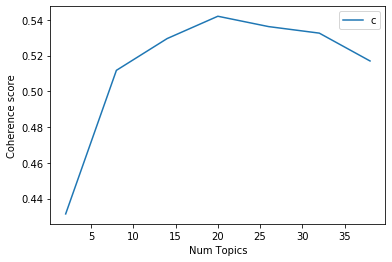

In [98]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [99]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4314
Num Topics = 8  has Coherence Value of 0.5117
Num Topics = 14  has Coherence Value of 0.5295
Num Topics = 20  has Coherence Value of 0.542
Num Topics = 26  has Coherence Value of 0.5362
Num Topics = 32  has Coherence Value of 0.5326
Num Topics = 38  has Coherence Value of 0.517


In [100]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.048*"test" + 0.035*"detection" + 0.030*"sample" + 0.029*"method" + '
  '0.022*"detect" + 0.020*"assay" + 0.016*"develop" + 0.016*"diagnostic" + '
  '0.015*"clinical" + 0.015*"positive"'),
 (1,
  '0.071*"study" + 0.062*"result" + 0.060*"high" + 0.055*"level" + '
  '0.048*"increase" + 0.032*"show" + 0.031*"compare" + 0.031*"significantly" + '
  '0.025*"low" + 0.022*"significant"'),
 (2,
  '0.028*"health" + 0.024*"care" + 0.015*"hospital" + 0.012*"management" + '
  '0.012*"risk" + 0.011*"practice" + 0.011*"medical" + 0.010*"conduct" + '
  '0.009*"measure" + 0.009*"conclusion"'),
 (3,
  '0.102*"disease" + 0.050*"infectious" + 0.027*"population" + 0.026*"risk" + '
  '0.026*"emerge" + 0.026*"outbreak" + 0.016*"country" + 0.015*"transmission" '
  '+ 0.014*"pathogen" + 0.012*"control"'),
 (4,
  '0.055*"model" + 0.023*"case" + 0.021*"number" + 0.019*"network" + '
  '0.017*"epidemic" + 0.016*"transmission" + 0.014*"estimate" + 0.013*"time" + '
  '0.013*"rate" + 0.012*"spread"'),
 (5,
 

### Finding the dominant topic in aech sentences

In [101]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
   # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [102]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1845,"study, result, high, level, increase, show, co...","[abstract, objectives, this, study, was, condu..."
1,1,0.0,0.3004,"test, detection, sample, method, detect, assay...","[abstract, recu, et, accepte, le, fevrier, les..."
2,2,8.0,0.0730,"group, calf, day, control, study, age, dog, we...","[abstract, ief, isoelectric, focusing, nc, nit..."
3,3,0.0,0.0500,"test, detection, sample, method, detect, assay...",[]
4,4,1.0,0.2112,"study, result, high, level, increase, show, co...","[abstract, bestatin, an, inhibitor, of, leucin..."
5,5,4.0,0.4477,"model, case, number, network, epidemic, transm...","[abstract, breathing, is, high, risk, behavior..."
6,6,19.0,0.1291,"infection, virus, respiratory, viral, child, a...","[abstract, background, human, coronavirus, nl,..."
7,7,0.0,0.3517,"test, detection, sample, method, detect, assay...","[abstract, loop, mediated, isothermal, amplifi..."
8,8,9.0,0.2621,"protein, bind, structure, peptide, domain, str...","[abstract, the, spike, protein, of, porcine, e..."
9,9,4.0,0.2975,"model, case, number, network, epidemic, transm...","[abstract, during, outbreaks, of, communicable..."


### Finding the most representaive document for each topic

In [103]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6314,"test, detection, sample, method, detect, assay...","[abstract, publicly, funded, repositories, suc..."
1,1.0,0.3657,"study, result, high, level, increase, show, co...","[abstract, background, previous, pharmaco, epi..."
2,2.0,0.4870,"health, care, hospital, management, risk, prac...","[abstract, background, inclusion, of, reusable..."
3,3.0,0.4474,"disease, infectious, population, risk, emerge,...","[abstract, zoonotic, diseases, cause, millions..."
4,4.0,0.5547,"model, case, number, network, epidemic, transm...","[abstract, to, demonstrate, the, differences, ..."


### Topic distribution across documents

In [104]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics[:19]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"study, result, high, level, increase, show, co...",2781.0,0.3906
1.0,0.0,"test, detection, sample, method, detect, assay...",69.0,0.0097
2.0,8.0,"group, calf, day, control, study, age, dog, we...",289.0,0.0406
3.0,0.0,"test, detection, sample, method, detect, assay...",210.0,0.0295
4.0,1.0,"study, result, high, level, increase, show, co...",242.0,0.0340
5.0,4.0,"model, case, number, network, epidemic, transm...",332.0,0.0466
6.0,19.0,"infection, virus, respiratory, viral, child, a...",159.0,0.0223
7.0,0.0,"test, detection, sample, method, detect, assay...",292.0,0.0410
8.0,9.0,"protein, bind, structure, peptide, domain, str...",198.0,0.0278
9.0,4.0,"model, case, number, network, epidemic, transm...",388.0,0.0545
